# Noise2noise

Testing noise2noise (Lehtinen et al., 2018, https://arxiv.org/abs/1803.04189) on MNIST with simple gaussian noise.

## Background

The task of denoising consists of mapping corrupted inputs to clean outputs. This task can be learned as well by training a regression model (e.g. neural network). Training CNNs for denoising was done with pairs of corrupted inputs $\hat x_i$ and clean targets $y_i$. Generating clean target images, however, can be difficult/tedious (requiring e.g. long exposure or to take several images to get a clean one) or maybe even impossible (MRI).

In this work, Lehtinen et al. show that it is possible to train CNNs on denoising using pairs only of corrupted images at 
equal and sometimes even better performance. A single training example $(\hat x_i, \hat y_i)$ in this case consists of the same images with different noise as input and target.

From a theoretical perspective, consider a CNN $f_{\theta}(x)$ trained to minimize the L2 loss. The optimal solution is given by the conditional mean

\begin{equation}
f_{\theta}(x) = \mathbb{E}[y|x],
\end{equation}

where $y$ is the target distribution. However, the results is unchanged if the distribution $y$ is replaced with a distribution $\hat y$ with the same conditional mean, i.e. $\mathbb{E}[\hat y|x] = \mathbb{E}[y|x]$. Thus, in the case of denoising, we we replace the clean targets with targets that have the same mean, the results of the optimization is the same given infinite data (for a finite data, the variance is calculated in the paper). Minimizing the L2 loss can thus be applied to additive zero-mean gaussian noise or poisson noise which are both zero mean (poisson noise for grayscale images consists of drawing each pixel intensity from a poisson distribution with the mean equal to the intensity in the clean image).
They also show that other loss functions such that the L1 loss which recovers the median of the target distribution can be used on image with a large outlier content.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

# Load the MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.asarray(x_train / 255.0, dtype=np.float32)
x_test = np.asarray(x_test / 255.0, dtype=np.float32)
train_cat_idx = [np.where(y_train == i)[0] for i in range(0, 10)]
test_cat_idx = [np.where(y_test == i)[0] for i in range(0, 10)]

In [3]:
def plot(samples, figsize=(10, 2), gspec=(1, 5)):
    # simple plotting utility for samples
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(*gspec)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')
        plt.clim([0, 1])

    return fig

Random examples for the different digits (classes):


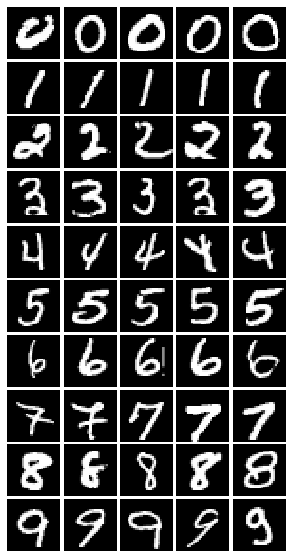

In [4]:
sample_idx = np.asarray([np.random.choice(x, 5) for x in train_cat_idx]).flatten()
print('Random examples for the different digits (classes):')
f = plot(x_train[sample_idx, :, :], figsize=(5, 10), gspec=(10, 5))

In [5]:
buffer_size = 60000
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(np.expand_dims(x_train, -1))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(np.expand_dims(x_test, -1)).batch(10000)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
next_element = iterator.get_next()
train_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

# Noise model

Here, we use simple additive gaussian noise. The standard deviation is sampled from a uniform distribution separately for each element in a batch.

In [6]:
def add_gaussian_noise(x, std=0.5):
    with tf.variable_scope('noise_model'):
        std = tf.random_uniform(tf.shape(x)[:1], minval=0, maxval=std)
        std = tf.reshape(std, [-1, 1, 1, 1])
        x = x + std * tf.random_normal(tf.shape(x))
        # x = tf.clip_by_value(x, 0, 1) # I had this in there first but of course this causes a non-zero mean
    return x

def add_gaussian_noise_np(x, std=0.5):
    std = std * np.random.rand(x.shape[0])
    shp = [1] * len(x.shape)
    shp[0] = -1
    x = x + np.reshape(std, shp) * np.random.randn(*x.shape)
    # x = np.clip(x, 0, 1)
    return x

def calculate_psnr(pred, target):
    # Peak-signal-to-noise-ratio for performance evaluation
    assert(pred.shape == target.shape)
    shp = np.asarray(pred.shape)
    pred = np.round(255 * pred)
    target = np.round(255 * target)
    mse = np.sum((pred.reshape((shp[0], -1)) - target.reshape((shp[0], -1))) ** 2, axis=1) / np.prod(shp[1:3])
    psnr = 20 * np.log10(255) - 10 * np.log10(mse)
    return psnr, mse

In [7]:
# this will be used for performance evaluation later
x_test_noisy = add_gaussian_noise_np(x_test, std=0.4)
x_test_noisy = x_test_noisy[:, :, :, np.newaxis]

In [8]:
corrupted_pair = [add_gaussian_noise(next_element), add_gaussian_noise(next_element)]
corrupted_clean_pair = [add_gaussian_noise(next_element), next_element]

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Samples from a single batch of input-output pairs used for training (note the different noise level both within a pair of  in- and output as well as between different pairs of a batch).

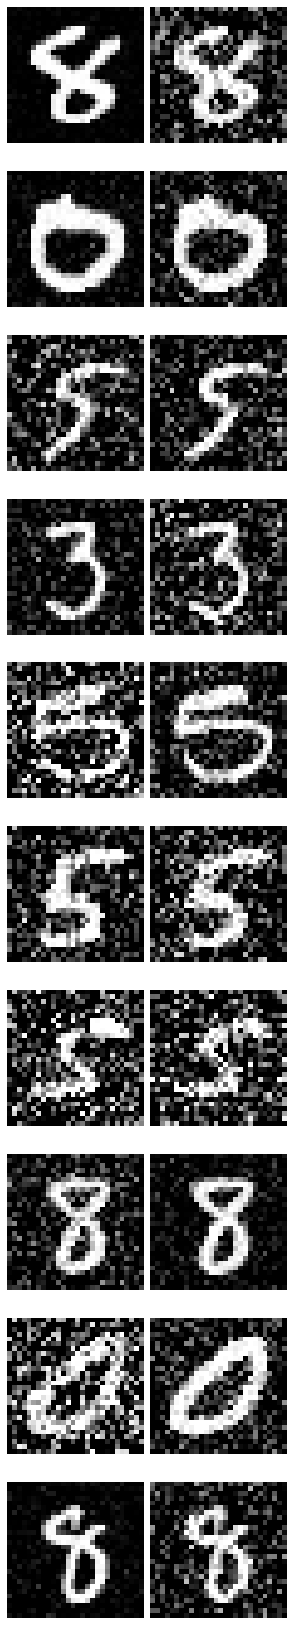

In [10]:
sess.run(train_init_op)
x_in, x_out = sess.run(corrupted_pair)
tmp = np.concatenate((x_in.reshape((-1, 28*28)), x_out.reshape((-1, 28*28))), axis=1).reshape((-1, 28, 28))
f = plot(tmp[:20, :, :], figsize=(5, 30), gspec=(10, 2))

# Network

A simple CNN is used consisting only of convolutional layer.

In [11]:
class Denoiser:
    
    def __init__(self, x_train, y_train, num_hidden_layer=5, filters=[10, ], kernel_size=[5, ], learning_rate=1e-3,
                 act=tf.nn.tanh):
        self.x_train = x_train
        self.y_train = y_train
        self.num_hidden_layer = num_hidden_layer
        if len(filters) == 1:
            filters = filters * num_hidden_layer
        elif len(filters) != num_hidden_layer:
            raise RuntimeError('Wrong filters specified.')
        self.filters = filters
        if len(kernel_size) == 1:
            kernel_size = kernel_size * num_hidden_layer
        elif len(kernel_size) != num_hidden_layer:
            raise RuntimeError('Wrong filters specified.')
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.activation = act

        # training
        self.pred_train = self.build_simple_cnn(self.x_train)
        self.loss = self.build_loss(self.y_train)
        self.solver = self.build_solver(self.learning_rate)
        
        # for prediction
        self.x_pl = tf.placeholder(dtype=tf.float32, shape=x_train.get_shape())
        self.pred = self.build_simple_cnn(self.x_pl, reuse=True)
    
    def build_simple_cnn(self, x, reuse=False):
        h = x
        with tf.variable_scope("cnet"):
            for l in range(self.num_hidden_layer):
                # tried leaky_relu first but network with clean targets had problems then
                h = tf.layers.conv2d(h, self.filters[l], self.kernel_size[l], padding='same',
                                     activation=self.activation, reuse=reuse, name='layer_{}'.format(l))
            h = tf.layers.conv2d(h, x.get_shape().as_list()[-1], 1, activation=tf.nn.sigmoid, name='output', reuse=reuse)
        return h
    
    def build_loss(self, target):
        loss = tf.losses.mean_squared_error(predictions=self.pred_train, labels=target)
        return loss
    
    def build_solver(self, lr=1e-3):
        solver = tf.train.AdamOptimizer(lr).minimize(self.loss)
        return solver

In [12]:
net = Denoiser(corrupted_pair[0], corrupted_pair[1])

# Training

Training a simple vanilla CNN on corrupted input-target pairs for denoising.

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
num_it = 1000
log_steps = 500
tr_loss = np.zeros(num_it)
t_0 = time.time()

sess.run(train_init_op)
log_step = 0
for it in range(num_it):
    
    _, tr_loss[it] = sess.run([net.solver, net.loss])
    
    if (it + 1) % log_steps == 0 or it == 0:
        t = time.time()
        print('Iter: {}'.format(it+1))
        print('Loss: {:.4f}'.format(tr_loss[it]))
        print('Total runtime {:.2f}s'.format(t - t_0))
        print()

Iter: 1
Loss: 0.3329
Total runtime 0.94s

Iter: 500
Loss: 0.1042
Total runtime 178.64s

Iter: 1000
Loss: 0.0874
Total runtime 373.94s



# Denoise images from test set with different noise levels

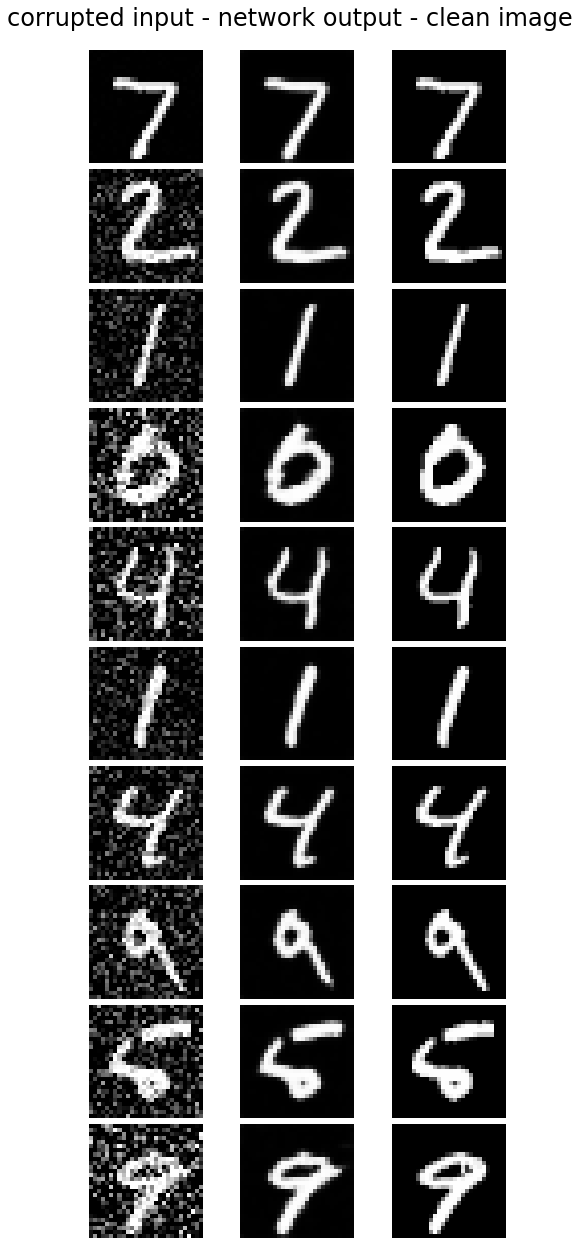

In [15]:
N = 10
x_ref = x_test_noisy[:N, :, :, :]
x_clean = x_test[:N, :, :]
pred = sess.run(net.pred, feed_dict={net.x_pl: x_ref})
tmp = np.concatenate((x_ref.reshape((-1, 28*28)), pred.reshape((-1, 28*28)), x_clean.reshape((-1, 28*28))), axis=1)
tmp = tmp.reshape((-1, 28, 28))
f = plot(tmp, figsize=(8, 20), gspec=(N, 3))
f.suptitle('corrupted input - network output - clean image', fontsize=24);
f.subplots_adjust(top=0.95)

In [16]:
pred = sess.run(net.pred, feed_dict={net.x_pl: x_test_noisy})
pred = np.squeeze(pred)

psnr, mse = calculate_psnr(x_test, pred)
print('PSNR result (corrupted input and target): {:.2f} +/- {:.2f}'.format(np.mean(psnr), np.std(psnr)))

PSNR result (corrupted input and target): 25.19 +/- 2.90


# Train on clean targets for comparison

Note that the loss is of course lower in the control experiment since the targets are not corrupted by random noise which cannot be predicted from the input.

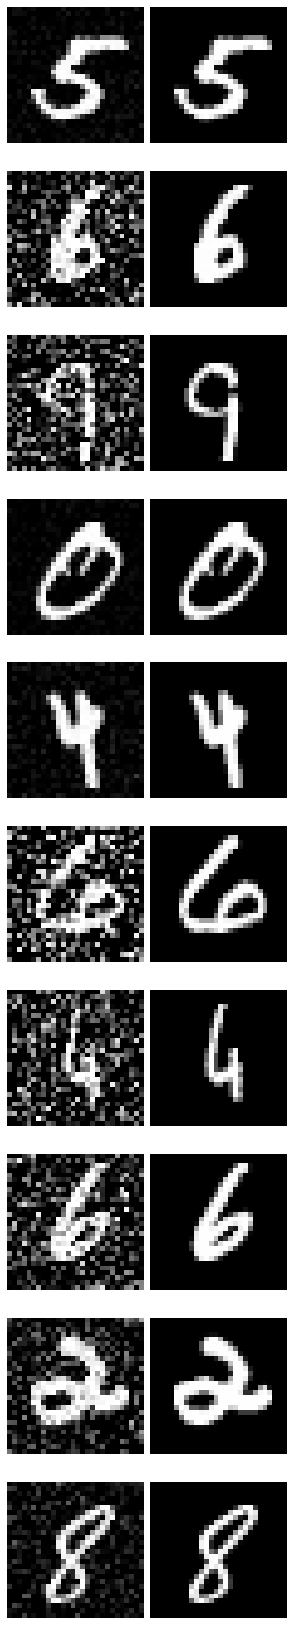

In [17]:
x_in, x_out = sess.run(corrupted_clean_pair)
tmp = np.concatenate((x_in.reshape((-1, 28*28)), x_out.reshape((-1, 28*28))), axis=1).reshape((-1, 28, 28))
f = plot(tmp[:20, :, :], figsize=(5, 30), gspec=(10, 2))

In [18]:
with tf.variable_scope('clean_targets'):
    net_cor_clean = Denoiser(corrupted_clean_pair[0], corrupted_clean_pair[1])

In [19]:
init_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='clean_targets')
sess.run(tf.variables_initializer(var_list=init_var))

In [20]:
num_it = 1000
log_steps = 500
tr_loss = np.zeros(num_it)
t_0 = time.time()

sess.run(train_init_op)
log_step = 0
for it in range(num_it):
    
    _, tr_loss[it] = sess.run([net_cor_clean.solver, net_cor_clean.loss])
    
    if (it + 1) % log_steps == 0 or it == 0:
        t = time.time()
        print('Iter: {}'.format(it+1))
        print('Loss: {:.4f}'.format(tr_loss[it]))
        print('Total runtime {:.2f}s'.format(t - t_0))
        print()

Iter: 1
Loss: 0.2303
Total runtime 0.48s

Iter: 500
Loss: 0.0053
Total runtime 188.00s

Iter: 1000
Loss: 0.0051
Total runtime 373.61s



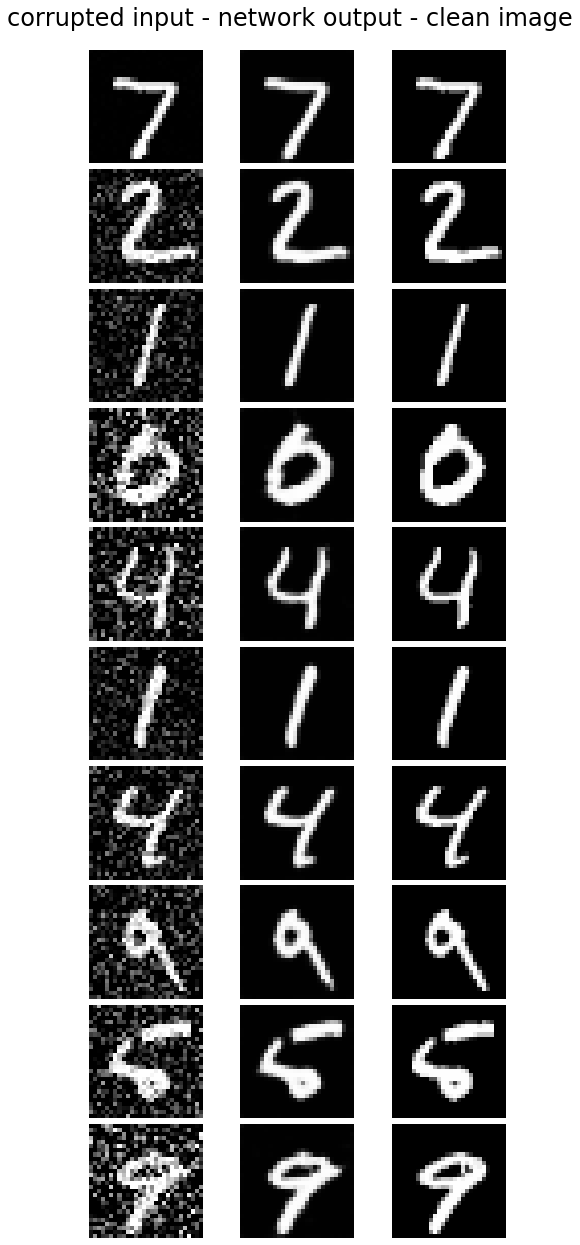

In [21]:
N = 10
x_ref = x_test_noisy[:N, :, :, :]
x_clean = x_test[:N, :, :]
pred = sess.run(net_cor_clean.pred, feed_dict={net_cor_clean.x_pl: x_ref})
tmp = np.concatenate((x_ref.reshape((-1, 28*28)), pred.reshape((-1, 28*28)), x_clean.reshape((-1, 28*28))), axis=1)
tmp = tmp.reshape((-1, 28, 28))
f = plot(tmp, figsize=(8, 20), gspec=(N, 3))
f.suptitle('corrupted input - network output - clean image', fontsize=24);
f.subplots_adjust(top=0.95)

In [22]:
pred_control = sess.run(net_cor_clean.pred, feed_dict={net_cor_clean.x_pl: x_test_noisy})
pred_control = np.squeeze(pred_control)

psnr_control, mse_control = calculate_psnr(x_test, pred_control)
print('PSNR result (corrupted input and clean target): {:.2f} +/- {:.2f}'.
      format(np.mean(psnr_control), np.std(psnr_control)))

PSNR result (corrupted input and clean target): 25.32 +/- 2.93


## Result

In [23]:
print('PSNR result (corrupted input and corrupted target): {:.2f} +/- {:.2f}'.format(np.mean(psnr), np.std(psnr)))
print('PSNR result (corrupted input and clean target): {:.2f} +/- {:.2f}'.
      format(np.mean(psnr_control), np.std(psnr_control)))

PSNR result (corrupted input and corrupted target): 25.19 +/- 2.90
PSNR result (corrupted input and clean target): 25.32 +/- 2.93


The training with corrupted input-target pairs thus results in the same performance as training with clean pairs.